In [10]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image
import time
import requests
import zipfile
import os

In [11]:
# import os
# import shutil
# # copy dán vào link để lấy
# url = 'https://storage.googleapis.com/emcassavadata/cassavaleafdata.zip'

# zip_path = './data/cassavaleafdata.zip'
# extract_to = './data'

# # Giải nén tệp ZIP
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

# print(f"Extracted to: {extract_to}")


# # Xóa tệp ZIP
# file_to_delete = './data/cassavaleafdata.zip'
# os.remove(file_to_delete)
# print(f"File deleted: {file_to_delete}")

In [15]:
data_paths = {
    'train': './train',
    'valid': './validation',
    'test': './test'
}

def loader(path):
    return Image.open(path)

img_size = 150
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(
    root=data_paths['train'],
    loader=loader,
    transform=train_transforms
)
valid_data = datasets.ImageFolder(
    root=data_paths['valid'],
    transform=train_transforms
)

test_data = datasets.ImageFolder(
    root=data_paths['test'],
    transform=train_transforms
)

batch_size = 256
train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = data.DataLoader(valid_data, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [16]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=5, padding='same'
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(16 * 35 * 35, 120)
        self.linear2 = nn.Linear(120, 84)
        self.out = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.linear1(outputs)
        outputs = self.linear2(outputs)
        outputs = self.out(outputs)
        return outputs

In [17]:
def compute_accuracy(prediction, labels):
    total_acc = (prediction.argmax(dim=1) == labels).sum().item()
    return total_acc

def train(model: LeNetClassifier, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model.forward(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        loss.backward()
        # chuẩn hóa norm rồi giới hạn maximum là 0.1
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        total_acc += compute_accuracy(predictions, labels)
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "|wait{} | epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    elapsed, epoch, idx, len(
                        train_dataloader), total_acc / total_count
                )
            )

            start_time = time.time()

    total_acc = total_acc / total_count
    total_loss = sum(losses) / len(losses)

    return total_acc, total_loss


def evaluate(model, criterion, device, valid_dataloader):
    model.eval()

    total_acc, total_count = 0, 0
    losses = []
    for idx, (inputs, labels) in enumerate(valid_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        predictions = model.forward(inputs)

        loss = criterion(predictions, labels)
        losses.append(loss.item())

        total_acc += compute_accuracy(predictions, labels)
        total_count += labels.size(0)

    total_acc = total_acc / total_count
    total_loss = sum(losses) / len(losses)

    return total_acc, total_loss

In [18]:
num_classes = len(train_loader.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 10
save_model = ''

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs + 1):
    e_start_time = time.time()

    train_acc, train_loss = train(
        lenet_model, optimizer, criterion, train_loader, device, epoch=0)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(
        lenet_model, criterion, device, valid_loader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/lenet_model.pt')

    print("-" * 59)
    print("| End of epoch {:3d} | Time : {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
          "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f}".format(
              epoch, time.time() - e_start_time, train_acc, train_loss, eval_acc, eval_loss))
    print("-")

-----------------------------------------------------------
| End of epoch   1 | Time : 38.67s | Train Accuracy    0.448 | Train Loss    1.717 | Valid Accuracy    0.470 | Valid Loss    1.435
-
-----------------------------------------------------------
| End of epoch   2 | Time : 41.40s | Train Accuracy    0.470 | Train Loss    1.335 | Valid Accuracy    0.473 | Valid Loss    1.407
-
-----------------------------------------------------------
| End of epoch   3 | Time : 38.40s | Train Accuracy    0.490 | Train Loss    1.296 | Valid Accuracy    0.497 | Valid Loss    1.418
-
-----------------------------------------------------------
| End of epoch   4 | Time : 38.67s | Train Accuracy    0.517 | Train Loss    1.259 | Valid Accuracy    0.493 | Valid Loss    1.405
-
-----------------------------------------------------------
| End of epoch   5 | Time : 37.44s | Train Accuracy    0.519 | Train Loss    1.244 | Valid Accuracy    0.507 | Valid Loss    1.369
-
-----------------------------------

In [20]:
lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))
lenet_model.eval()

test_acc, test_loss = evaluate(lenet_model, criterion, device, test_loader)
test_acc, test_loss

<ipython-input-20-60f9f64b9697>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_model + '/lenet_model.pt'))


(0.5607427055702918, 1.257632914930582)

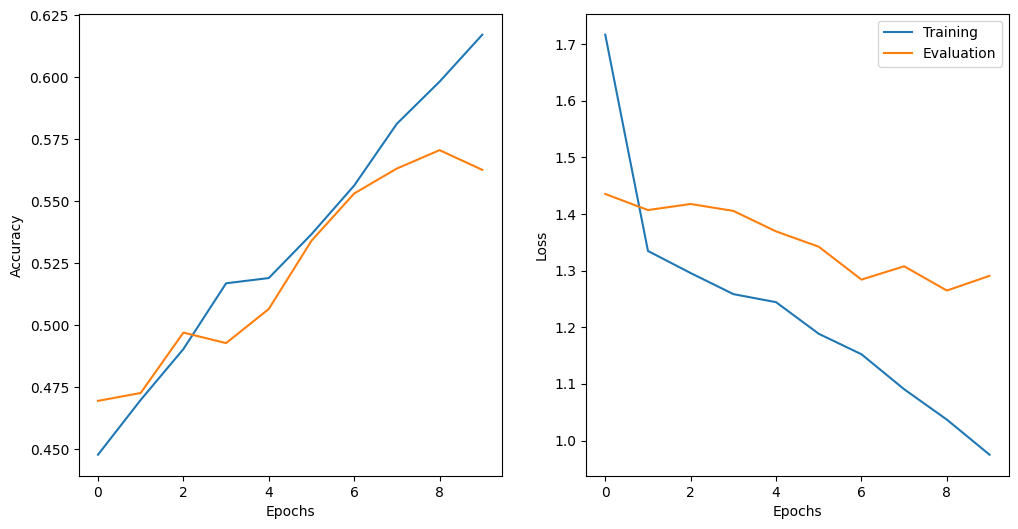

In [22]:
def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses)